# Install Dependencies

In [ ]:
!pip install transformers[torch] accelerate evaluate rouge-score nltk sentencepiece bert-score matplotlib seaborn datasets pandas -q

In [ ]:
!pip install --upgrade datasets huggingface_hub -q
!pip install fsspec==2023.10.0 -q

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Imports, Seed, and Device Setup
* `transformers[torch]`: Hugging Face's library for state-of-the-art machine learning models (specifically with PyTorch support).
* `accelerate`: Simplifies running PyTorch code on various hardware setups (CPU, GPU, TPU).
* `evaluate`: Hugging Face's library for model evaluation metrics.
* `rouge-score`, `nltk`, `sentencepiece`, `bert-score`: Libraries for specific metrics and text processing.
* `matplotlib`, `seaborn`: For plotting and visualization.
* `datasets`: Hugging Face's library for easily loading and processing datasets.
* `pandas`: For data manipulation and analysis.
* `huggingface_hub`: For interacting with the Hugging Face Hub (e.g., downloading models, datasets).

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    AutoConfig,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate
import nltk
from tqdm.auto import tqdm

## Punkt sentence tokenizer for NLTK (used by ROUGE, BERTScore)

* **Importing necessary modules**: Standard libraries for data handling, PyTorch, Hugging Face components, and plotting.
* **Seed initialization**: `set_seed(42)` ensures reproducibility of results by setting random seeds for Python's `random`, `numpy`, and `torch`.
* **Device configuration**: `device` is set to CUDA (GPU) if available, otherwise CPU. This ensures models are run on the most performant hardware available.
* **NLTK Punkt download**: Ensures the sentence tokenizer required for some metrics is available.



In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download("punkt", quiet=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Dataset

* It first attempts to load the full dataset.
* Then, it creates a smaller, manageable subset (`dataset_subset_size`) to ensure that the subsequent steps (especially fine-tuning and benchmarking) run relatively quickly for demonstration.
* This subset is then split into `train` and `test` sets. The `train` set will be used for fine-tuning, and the `test` set (`dataset_for_benchmarking`) will be used for evaluating pre-trained models (zero/few-shot) and the fine-tuned model.


In [ ]:
from datasets import load_dataset, DatasetDict
full_dataset = None
try:
    print("Attempting to load dataset FreedomIntelligence/RAG-Instruct...")
    dataset_repo = load_dataset("FreedomIntelligence/RAG-Instruct")

    print(f"Available splits: {list(dataset_repo.keys())}")

    if "train" in dataset_repo:
        full_dataset = dataset_repo["train"]
        print(f"Successfully loaded 'train' split with {len(full_dataset)} examples.")
    else:
        if len(dataset_repo.keys()) == 1:
             print(f"Only one split found: {list(dataset_repo.keys())[0]}. Assuming it's the 'train' data.")
             full_dataset = dataset_repo[list(dataset_repo.keys())[0]]
             print(f"Loaded split with {len(full_dataset)} examples.")
        else:
             print("ERROR: The 'train' split was not found. Available splits: " + str(list(dataset_repo.keys())))

except Exception as e:
    print(f"An error occurred during dataset loading: {e}")
    raise

if full_dataset:
    print(f"Successfully loaded {len(full_dataset)} examples from the dataset.")

    # code for creating subsets:
    dataset_subset_size = 1000
    if len(full_dataset) > dataset_subset_size:
        shuffled_dataset = full_dataset.shuffle(seed=42)
        train_test_ratio = 200 / dataset_subset_size if dataset_subset_size > 200 else 0.2
        if train_test_ratio >= 1.0: train_test_ratio = 0.5
        if train_test_ratio <= 0.0: train_test_ratio = 0.1

        train_test_split = shuffled_dataset.train_test_split(test_size=train_test_ratio, seed=42)
        dataset_for_finetuning = DatasetDict({
            'train': train_test_split['train'],
            'test': train_test_split['test']
        })
        dataset_for_benchmarking = dataset_for_finetuning['test']
        dataset_for_qualitative_test = dataset_for_finetuning['test']
    else:
        test_size_small_dataset = 0.2 if len(full_dataset) * 0.2 >= 1 else max(1/len(full_dataset) if len(full_dataset) > 0 else 0.1, 0.1)
        if len(full_dataset) <= 1:
            dataset_for_finetuning = DatasetDict({'train': full_dataset, 'test': full_dataset})
        else:
            train_test_split = full_dataset.train_test_split(test_size=test_size_small_dataset, seed=42)
            dataset_for_finetuning = DatasetDict({
                'train': train_test_split['train'],
                'test': train_test_split['test']
            })
        dataset_for_benchmarking = dataset_for_finetuning['test']
        dataset_for_qualitative_test = dataset_for_finetuning['test']

    print(f"Using {len(dataset_for_finetuning['train'])} examples for fine-tuning training.")
    print(f"Using {len(dataset_for_benchmarking)} examples for zero/few-shot benchmarking and fine-tuned model evaluation.")
else:
    print("Dataset loading failed. Cannot proceed.")

Attempting to load dataset FreedomIntelligence/RAG-Instruct...
Available splits: ['train']
Successfully loaded 'train' split with 40541 examples.
Successfully loaded 40541 examples from the dataset.
Using 32432 examples for fine-tuning training.
Using 8109 examples for zero/few-shot benchmarking and fine-tuned model evaluation.


# Prompt Formatting

* It can generate **zero-shot** prompts (context and question only) or **few-shot** prompts (includes a few examples of context, question, and answer before the actual query).
* For context, it uses only the first document provided in the `documents` field to keep the prompt length manageable. A separator `---` is used between few-shot examples.


In [ ]:
def construct_prompt(example, shots_examples=None):
    prompt = ""
    if shots_examples:
        for s_example in shots_examples:
            ctx = "\n".join(s_example["documents"][:1]) if s_example["documents"] else "No context provided."
            prompt += f"### Context:\n{ctx}\n\n### Question: {s_example['question']}\n### Answer: {s_example['answer']}\n\n---\n\n"

    main_ctx = "\n".join(example["documents"][:1]) if example["documents"] else "No context provided."
    prompt += f"### Context:\n{main_ctx}\n\n### Question: {example['question']}\n### Answer:"
    return prompt

sample_example = dataset_for_benchmarking[0]
print("--- Zero-Shot Prompt ---")
print(construct_prompt(sample_example))

if len(dataset_for_benchmarking) > 5:
    print("\n--- Few-Shot Prompt (2-shot example) ---")
    few_shot_examples = [dataset_for_benchmarking[i+1] for i in range(2)]
    print(construct_prompt(sample_example, shots_examples=few_shot_examples))

--- Zero-Shot Prompt ---
### Context:
may be efficacious in improving cognitive function, global clinical status, and activities of daily living for individuals with Alzheimer’s disease. However, due to the poor size and quality of the clinical trials reviewed, huperzine A should not be recommended as a treatment for Alzheimer’s disease unless further high quality studies confirm its beneficial effects. Huperzine A is also marketed as a dietary supplement with claims made for its ability to improve memory and mental function. Huperzine A has also been postulated as a potential treatment for myasthenia gravis. Huperzine A may present with mild cholinergic side effects such as nausea,

### Question: Which substance has been shown to affect neurotransmitter release and autonomic responses in MS patients?
### Answer:

--- Few-Shot Prompt (2-shot example) ---
### Context:
of the grouping is questionable given that it is generally agreed to be an arbitrary (polyphyletic) grouping of taxa. He

# LLM Inference and Evaluation (Zero/Few-Shot)

* Loads a specified pre-trained sequence-to-sequence model and its tokenizer from Hugging Face.
* Iterates through a sample of the dataset (`num_samples`).
* For each data point, it constructs a prompt using `construct_prompt` (zero-shot or few-shot).
* Tokenizes the prompt and feeds it to the model to generate a prediction.
* `max_input_len` and `max_output_len` control the truncation of input and the length of generated text.
* It uses `torch.no_grad()` to disable gradient calculations, saving memory and speeding up inference.
* Collects prompts, predictions, and reference answers into a Pandas DataFrame.
* Includes error handling for model loading.

In [ ]:
def run_inference(model_name, dataset_to_eval, num_shots=0, num_samples=50, max_input_len=1024, max_output_len=256):

    records = []
    is_causal_lm = False

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)

        if any(arch.endswith("ForCausalLM") for arch in config.architectures) or \
           config.model_type in ["mistral", "falcon", "gpt_neox", "llama", "rwkv"]:
            is_causal_lm = True
            print(f"Loading {model_name} as a Causal LM.")
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                config=config,
                trust_remote_code=True,
                torch_dtype=torch.bfloat16 if torch.cuda.is_available() else "auto",
                device_map="auto"
            )
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
        else:
            print(f"Loading {model_name} as a Seq2Seq LM.")
            model = AutoModelForSeq2SeqLM.from_pretrained(
                model_name,
                config=config,
                trust_remote_code=True,
                device_map="auto" # use device_map for Seq2Seq
            )

        model.eval() # Set model to evaluation mode

    except Exception as e:
        print(f"Error loading {model_name}: {e}. Skipping.")
        return pd.DataFrame()

    if num_samples > len(dataset_to_eval):
        num_samples = len(dataset_to_eval)
    if num_shots >= num_samples :
        num_shots = max(0, num_samples - 1)

    eval_indices = random.sample(range(len(dataset_to_eval)), num_samples) if num_samples < len(dataset_to_eval) else list(range(num_samples))
    eval_data = dataset_to_eval.select(eval_indices)

    for i, example in enumerate(tqdm(eval_data, desc=f"{model_name} | {num_shots}-shot")):
        shots_examples = None
        if num_shots > 0:
            available_shot_indices = [idx for idx in range(len(dataset_to_eval)) if idx not in eval_indices[:i+1]]
            shot_indices = random.sample(available_shot_indices, num_shots) if len(available_shot_indices) >= num_shots else random.sample(range(len(dataset_to_eval)), min(num_shots, len(dataset_to_eval)))
            shots_examples = dataset_to_eval.select(shot_indices)

        prompt = construct_prompt(example, shots_examples=shots_examples)

        if is_causal_lm:
            pass

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            output_sequences = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=max_output_len,
                do_sample=False,
                num_beams=1,
                pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
            )

        prediction = ""
        if is_causal_lm:
            input_ids_length = inputs["input_ids"].shape[1]
            generated_ids = output_sequences[0][input_ids_length:]
            prediction = tokenizer.decode(generated_ids, skip_special_tokens=True)
        else: # For Seq2Seq models
            prediction = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

        records.append({
            "model": model_name,
            "shots": num_shots,
            "prompt": prompt,
            "prediction": prediction.strip(),
            "reference": example["answer"].strip()
        })

    return pd.DataFrame(records)

# Metric Calculation

* Takes a DataFrame of predictions and references.
* Uses the `evaluate` library to compute:
    * **ROUGE** scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum): Measure overlap of n-grams and longest common subsequence between predictions and references. Good for summarization and generation tasks.
    * **BLEU** score: Measures precision of n-grams. Commonly used in machine translation.
    * **BERTScore**: Computes semantic similarity between predictions and references using BERT embeddings. Captures meaning better than n-gram overlap.
* It handles potential issues with empty predictions/references.

In [ ]:
def calculate_metrics(df_predictions):

    rouge_scorer = evaluate.load("rouge")
    bleu_scorer = evaluate.load("bleu")
    bert_scorer = evaluate.load("bertscore")

    predictions = df_predictions["prediction"].tolist()
    references = df_predictions["reference"].tolist()

    filtered_preds_refs = [(p, r) for p, r in zip(predictions, references) if p.strip() and r.strip()]
    if not filtered_preds_refs:
        print("Warning: No valid prediction/reference pairs to score after filtering empty strings.")
        return {
            "rouge1": 0, "rouge2": 0, "rougeL": 0, "rougeLsum": 0,
            "bleu": 0, "bertscore_precision": 0, "bertscore_recall": 0, "bertscore_f1": 0
        }

    filtered_predictions = [item[0] for item in filtered_preds_refs]
    filtered_references = [item[1] for item in filtered_preds_refs]

    if not filtered_predictions:
        print("Warning: All predictions were empty after filtering.")
        return {
            "rouge1": 0, "rouge2": 0, "rougeL": 0, "rougeLsum": 0,
            "bleu": 0, "bertscore_precision": 0, "bertscore_recall": 0, "bertscore_f1": 0
        }

    rouge_results = rouge_scorer.compute(predictions=filtered_predictions, references=filtered_references)
    bleu_results = bleu_scorer.compute(predictions=filtered_predictions, references=filtered_references)
    bertscore_results = bert_scorer.compute(predictions=filtered_predictions, references=filtered_references, lang="en")

    return {
        "rouge1": rouge_results["rouge1"],
        "rouge2": rouge_results["rouge2"],
        "rougeL": rouge_results["rougeL"],
        "rougeLsum": rouge_results["rougeLsum"],
        "bleu": bleu_results["bleu"],
        "bertscore_precision": float(np.mean(bertscore_results["precision"])),
        "bertscore_recall": float(np.mean(bertscore_results["recall"])),
        "bertscore_f1": float(np.mean(bertscore_results["f1"]))
    }

# Run Benchmark (Zero/Few-Shot)
* `benchmark_model_list`: Defines the LLMs you want to compare. I've selected `flan-t5-small` and `flan-t5-base` as they are manageable for typical Colab environments. You can add more models if your hardware allows.
* It iterates through each model and specified shot strategies (0, 1, and 3 shots).
* Calls `run_inference` to get predictions and `calculate_metrics` to evaluate them.
* Stores all results and raw predictions. The predictions are saved to `benchmark_predictions.csv`.


In [ ]:
benchmark_model_list = [
    "google/flan-t5-small",
    "google/flan-t5-base",
    "tiiuae/falcon-rw-1b",
    "mistralai/Mistral-7B-Instruct-v0.1" # OPTIONAL
]

all_benchmark_results = []
all_prediction_outputs = []
num_benchmark_samples = 50 # Number of samples from dataset_for_benchmarking to test on
                           # Reduce if running takes too long, especially for Mistral/Falcon

for model_name_iter in benchmark_model_list:
    for shots_iter in [0, 1, 3]: # Zero-shot, One-shot, Three-shot
        print(f"\nRunning benchmark for: {model_name_iter} with {shots_iter} shots...")

        df_output = run_inference(
            model_name_iter,
            dataset_for_benchmarking,
            num_shots=shots_iter,
            num_samples=num_benchmark_samples,
            max_input_len=768, # Increased slightly, Falcon/Mistral can handle longer contexts
            max_output_len=200 # Increased slightly for potentially more verbose answers
        )

        if not df_output.empty:
            metrics = calculate_metrics(df_output)
            metrics.update({"model": model_name_iter, "shots": shots_iter})
            all_benchmark_results.append(metrics)
            all_prediction_outputs.append(df_output)
            print(f"Metrics for {model_name_iter} ({shots_iter}-shot): {metrics}")
        else:
            print(f"Skipping metrics for {model_name_iter} ({shots_iter}-shot) due to empty output.")

# Consolidate all prediction outputs into a single DataFrame
if all_prediction_outputs:
    df_all_predictions = pd.concat(all_prediction_outputs, ignore_index=True)
    df_all_predictions.to_csv("benchmark_predictions.csv", index=False)
    print("\nAll benchmark predictions saved to benchmark_predictions.csv")
else:
    print("\nNo prediction outputs were generated to save.") # Added a message for empty case


if 'df_all_predictions' in globals() and not df_all_predictions.empty:
    print("\n--- Sample of LLM Benchmark Predictions ---")
    num_total_samples_to_show = 5
    if len(df_all_predictions) > 0:
        sample_display_df = df_all_predictions.sample(n=min(num_total_samples_to_show, len(df_all_predictions)), random_state=42)
    else:
        sample_display_df = pd.DataFrame()

    if not sample_display_df.empty:
        for index, row in sample_display_df.iterrows():
            print(f"\nModel: {row['model']}")
            print(f"Shots: {row['shots']}")
            prompt_display_length = 400
            truncated_prompt = row['prompt']
            if len(row['prompt']) > prompt_display_length:
                truncated_prompt = "..." + row['prompt'][-prompt_display_length:]
            print(f"Prompt (tail): {truncated_prompt}")
            print(f"Reference Answer: {row['reference']}")
            print(f"Predicted Answer: {row['prediction']}")
            print("-" * 70)
    else:
        print("No predictions available in df_all_predictions to display a sample for.")
elif 'all_prediction_outputs' in globals() and not all_prediction_outputs:
     print("\nNo benchmark predictions were generated (all_prediction_outputs is empty).")
else:
    print("\n`df_all_predictions` DataFrame not found or is empty. Cannot display sample predictions.")

# Create a DataFrame for metrics
df_metrics_summary = pd.DataFrame(all_benchmark_results)
if df_metrics_summary.empty:
    print("\nNo benchmark metrics were generated.")


Running benchmark for: google/flan-t5-small with 0 shots...
Loading google/flan-t5-small as a Seq2Seq LM.


google/flan-t5-small | 0-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-small (0-shot): {'rouge1': np.float64(0.0867179682267511), 'rouge2': np.float64(0.03205987246509717), 'rougeL': np.float64(0.07308426341980344), 'rougeLsum': np.float64(0.0725590116983319), 'bleu': 2.4540248986288043e-06, 'bertscore_precision': 0.856884673833847, 'bertscore_recall': 0.7992716002464294, 'bertscore_f1': 0.8267281639575959, 'model': 'google/flan-t5-small', 'shots': 0}

Running benchmark for: google/flan-t5-small with 1 shots...
Loading google/flan-t5-small as a Seq2Seq LM.


google/flan-t5-small | 1-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-small (1-shot): {'rouge1': np.float64(0.12283710211911363), 'rouge2': np.float64(0.04306027783241209), 'rougeL': np.float64(0.09448411430054399), 'rougeLsum': np.float64(0.0952604644848707), 'bleu': 0.002598425765396174, 'bertscore_precision': 0.8552561116218567, 'bertscore_recall': 0.8123276972770691, 'bertscore_f1': 0.8327980351448059, 'model': 'google/flan-t5-small', 'shots': 1}

Running benchmark for: google/flan-t5-small with 3 shots...
Loading google/flan-t5-small as a Seq2Seq LM.


google/flan-t5-small | 3-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-small (3-shot): {'rouge1': np.float64(0.04831676169720617), 'rouge2': np.float64(0.005123230294201442), 'rougeL': np.float64(0.04074335397560696), 'rougeLsum': np.float64(0.0408851725494637), 'bleu': 0.00012457989349200812, 'bertscore_precision': 0.8096587061882019, 'bertscore_recall': 0.7907727646827698, 'bertscore_f1': 0.7996179604530335, 'model': 'google/flan-t5-small', 'shots': 3}

Running benchmark for: google/flan-t5-base with 0 shots...
Loading google/flan-t5-base as a Seq2Seq LM.


google/flan-t5-base | 0-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-base (0-shot): {'rouge1': np.float64(0.08900492768660642), 'rouge2': np.float64(0.029591304445086487), 'rougeL': np.float64(0.07141319741079101), 'rougeLsum': np.float64(0.07278093110641179), 'bleu': 0.0008564051659754724, 'bertscore_precision': 0.8519871973991394, 'bertscore_recall': 0.7982360708713532, 'bertscore_f1': 0.8238436365127564, 'model': 'google/flan-t5-base', 'shots': 0}

Running benchmark for: google/flan-t5-base with 1 shots...
Loading google/flan-t5-base as a Seq2Seq LM.


google/flan-t5-base | 1-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-base (1-shot): {'rouge1': np.float64(0.13312327704080015), 'rouge2': np.float64(0.038373346936132716), 'rougeL': np.float64(0.0987489211349707), 'rougeLsum': np.float64(0.09906209609291311), 'bleu': 0.012549060557982158, 'bertscore_precision': 0.834630925655365, 'bertscore_recall': 0.8102322006225586, 'bertscore_f1': 0.8215787422657013, 'model': 'google/flan-t5-base', 'shots': 1}

Running benchmark for: google/flan-t5-base with 3 shots...
Loading google/flan-t5-base as a Seq2Seq LM.


google/flan-t5-base | 3-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for google/flan-t5-base (3-shot): {'rouge1': np.float64(0.054967337758678), 'rouge2': np.float64(0.0029387743531900075), 'rougeL': np.float64(0.04499053685747596), 'rougeLsum': np.float64(0.044852652045011626), 'bleu': 0.0, 'bertscore_precision': 0.8071429204940795, 'bertscore_recall': 0.7941748428344727, 'bertscore_f1': 0.8003229284286499, 'model': 'google/flan-t5-base', 'shots': 3}

Running benchmark for: tiiuae/falcon-rw-1b with 0 shots...
Loading tiiuae/falcon-rw-1b as a Causal LM.


modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-rw-1b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tiiuae/falcon-rw-1b | 0-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for tiiuae/falcon-rw-1b (0-shot): {'rouge1': np.float64(0.19054207621609576), 'rouge2': np.float64(0.05370192834279672), 'rougeL': np.float64(0.15368861722578198), 'rougeLsum': np.float64(0.12110207497060302), 'bleu': 0.03292046176549491, 'bertscore_precision': 0.8031499564647675, 'bertscore_recall': 0.8275803530216217, 'bertscore_f1': 0.8149844920635223, 'model': 'tiiuae/falcon-rw-1b', 'shots': 0}

Running benchmark for: tiiuae/falcon-rw-1b with 1 shots...
Loading tiiuae/falcon-rw-1b as a Causal LM.


tiiuae/falcon-rw-1b | 1-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for tiiuae/falcon-rw-1b (1-shot): {'rouge1': np.float64(0.19132203532197614), 'rouge2': np.float64(0.059428985558645626), 'rougeL': np.float64(0.1589540699563679), 'rougeLsum': np.float64(0.13667439999377193), 'bleu': 0.0320876586176657, 'bertscore_precision': 0.7995446062088013, 'bertscore_recall': 0.8302272117137909, 'bertscore_f1': 0.814204398393631, 'model': 'tiiuae/falcon-rw-1b', 'shots': 1}

Running benchmark for: tiiuae/falcon-rw-1b with 3 shots...
Loading tiiuae/falcon-rw-1b as a Causal LM.


tiiuae/falcon-rw-1b | 3-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for tiiuae/falcon-rw-1b (3-shot): {'rouge1': np.float64(0.11967548467983789), 'rouge2': np.float64(0.009595067741085966), 'rougeL': np.float64(0.0960336447527596), 'rougeLsum': np.float64(0.0986846817861159), 'bleu': 0.0, 'bertscore_precision': 0.7706972575187683, 'bertscore_recall': 0.8015162932872772, 'bertscore_f1': 0.7853618121147156, 'model': 'tiiuae/falcon-rw-1b', 'shots': 3}

Running benchmark for: mistralai/Mistral-7B-Instruct-v0.1 with 0 shots...
Loading mistralai/Mistral-7B-Instruct-v0.1 as a Causal LM.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

mistralai/Mistral-7B-Instruct-v0.1 | 0-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for mistralai/Mistral-7B-Instruct-v0.1 (0-shot): {'rouge1': np.float64(0.32573390480158787), 'rouge2': np.float64(0.12785341770288433), 'rougeL': np.float64(0.22098759214346203), 'rougeLsum': np.float64(0.2335280748855355), 'bleu': 0.08952827095839057, 'bertscore_precision': 0.8807476341724396, 'bertscore_recall': 0.8553164148330689, 'bertscore_f1': 0.8675078797340393, 'model': 'mistralai/Mistral-7B-Instruct-v0.1', 'shots': 0}

Running benchmark for: mistralai/Mistral-7B-Instruct-v0.1 with 1 shots...
Loading mistralai/Mistral-7B-Instruct-v0.1 as a Causal LM.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

mistralai/Mistral-7B-Instruct-v0.1 | 1-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for mistralai/Mistral-7B-Instruct-v0.1 (1-shot): {'rouge1': np.float64(0.33818711305224464), 'rouge2': np.float64(0.12372733344606032), 'rougeL': np.float64(0.21925731306252128), 'rougeLsum': np.float64(0.22438933694925248), 'bleu': 0.0863621240388297, 'bertscore_precision': 0.8689013934135437, 'bertscore_recall': 0.865259096622467, 'bertscore_f1': 0.866859519481659, 'model': 'mistralai/Mistral-7B-Instruct-v0.1', 'shots': 1}

Running benchmark for: mistralai/Mistral-7B-Instruct-v0.1 with 3 shots...
Loading mistralai/Mistral-7B-Instruct-v0.1 as a Causal LM.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

mistralai/Mistral-7B-Instruct-v0.1 | 3-shot:   0%|          | 0/50 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for mistralai/Mistral-7B-Instruct-v0.1 (3-shot): {'rouge1': np.float64(0.1555913378273005), 'rouge2': np.float64(0.009416111564165334), 'rougeL': np.float64(0.10726871732308244), 'rougeLsum': np.float64(0.11384621817501736), 'bleu': 0.0045831047821051464, 'bertscore_precision': 0.8084014165401459, 'bertscore_recall': 0.8117152941226959, 'bertscore_f1': 0.8099483859539032, 'model': 'mistralai/Mistral-7B-Instruct-v0.1', 'shots': 3}

All benchmark predictions saved to benchmark_predictions.csv

--- Sample of LLM Benchmark Predictions ---

Model: google/flan-t5-small
Shots: 3
Prompt (tail): ...f farmers in Vietnam being paid over the world price in the 1980s, planting lots of coffee, then flooding the world market in the 1990s. The fair trade minimum price means that when the world market price collapses, it is the non-fair trade

### Question: What would be useful to know to determine the effectiveness of fair trade in supporting farmers without negatively impacting others?
### An

# Visualize Benchmark Results

* It first creates a shortened model name for better display.
* Prints a table of key metrics (ROUGE-L, BLEU, BERTScore F1).
* Generates line plots showing how ROUGE-L and BERTScore F1 change with the number of shots for each model, making it easy to compare their learning capabilities from in-context examples.



--- Benchmark Metrics Summary ---


,model_short,shots,rougeL,bleu,bertscore_f1
0,flan-t5-small,0,0.0731,0.0000,0.8267
1,flan-t5-small,1,0.0945,0.0026,0.8328
2,flan-t5-small,3,0.0407,0.0001,0.7996
3,flan-t5-base,0,0.0714,0.0009,0.8238
4,flan-t5-base,1,0.0987,0.0125,0.8216
5,flan-t5-base,3,0.0450,0.0000,0.8003
6,falcon-rw-1b,0,0.1537,0.0329,0.8150
7,falcon-rw-1b,1,0.1590,0.0321,0.8142
8,falcon-rw-1b,3,0.0960,0.0000,0.7854
9,Mistral-7B-Instruct-v0.1,0,0.2210,0.0895,0.8675


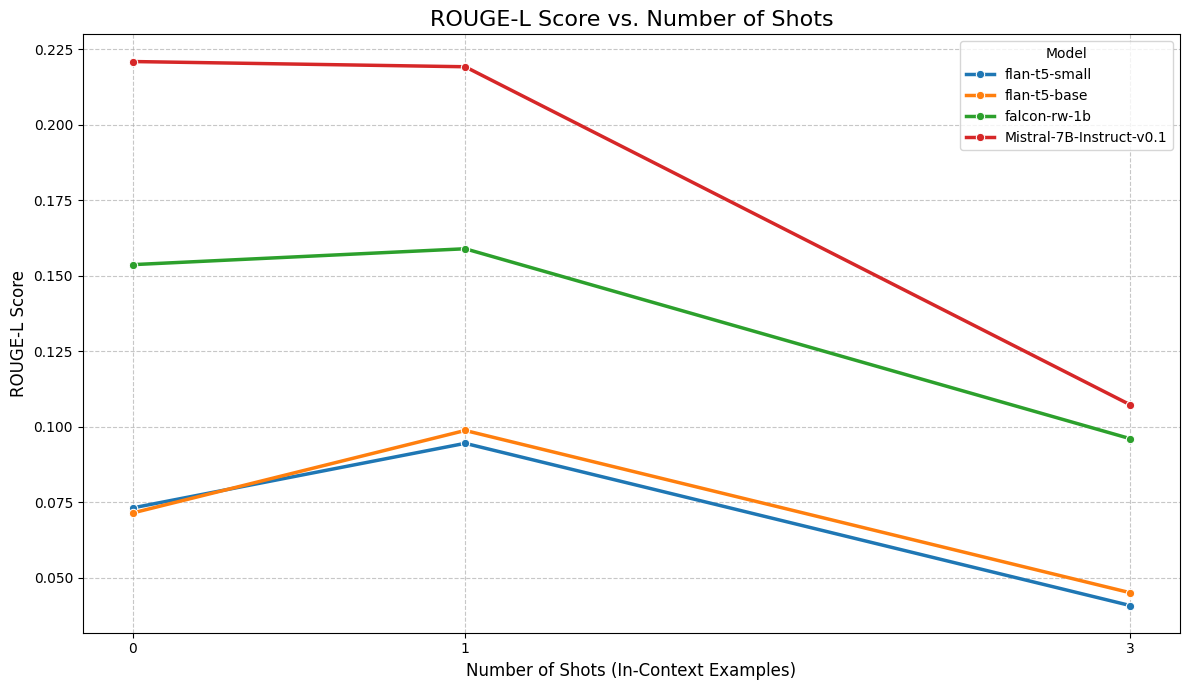

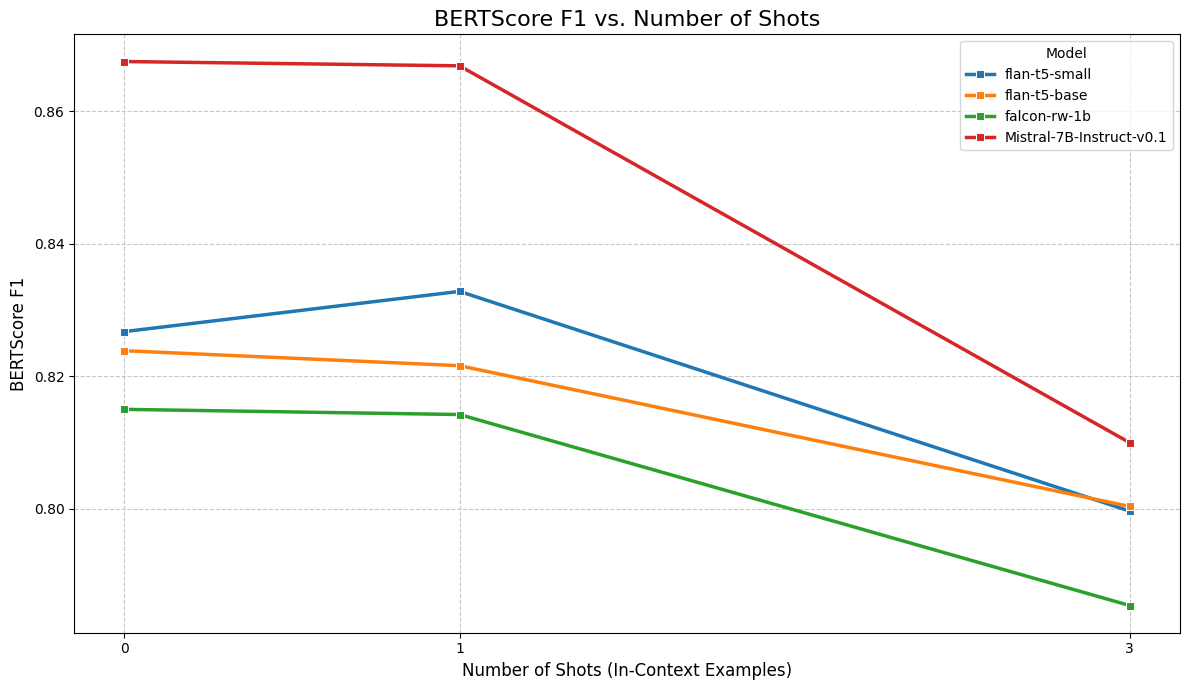

In [ ]:
if not df_metrics_summary.empty:
    df_metrics_summary["model_short"] = df_metrics_summary["model"].apply(lambda x: x.split("/")[-1])

    print("\n--- Benchmark Metrics Summary ---")
    display(df_metrics_summary[["model_short", "shots", "rougeL", "bleu", "bertscore_f1"]].round(4))

    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_metrics_summary, x="shots", y="rougeL", hue="model_short", marker="o", linewidth=2.5)
    plt.title("ROUGE-L Score vs. Number of Shots", fontsize=16)
    plt.xlabel("Number of Shots (In-Context Examples)", fontsize=12)
    plt.ylabel("ROUGE-L Score", fontsize=12)
    plt.xticks([0, 1, 3])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_metrics_summary, x="shots", y="bertscore_f1", hue="model_short", marker="s", linewidth=2.5)
    plt.title("BERTScore F1 vs. Number of Shots", fontsize=16)
    plt.xlabel("Number of Shots (In-Context Examples)", fontsize=12)
    plt.ylabel("BERTScore F1", fontsize=12)
    plt.xticks([0, 1, 3])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

else:
    print("No metrics summary to display as no benchmark results were generated.")